In [49]:
import importlib
import terrain
import wind
importlib.reload(terrain)
importlib.reload(wind)

SyntaxError: expected ':' (wind.py, line 189)

In [6]:
# Load terrain aspect dataset (pre-computed 1km)
terrain_ds = terrain.load_terrain_aspect_dataset()
terrain_ds

Loaded terrain aspect dataset: 232 x 772


<xarray.Dataset> Size: 6MB
Dimensions:       (latitude: 232, longitude: 772)
Coordinates:
  * latitude      (latitude) float64 2kB 48.0 47.99 47.97 ... 45.03 45.01 45.0
  * longitude     (longitude) float64 6kB 6.0 6.013 6.026 ... 15.97 15.99 16.0
Data variables:
    elevation     (latitude, longitude) float64 1MB ...
    aspect        (latitude, longitude) float64 1MB ...
    aspect_deg    (latitude, longitude) float64 1MB ...
    slope         (latitude, longitude) float64 1MB ...
    terrain_mask  (latitude, longitude) bool 179kB ...
Attributes:
    resolution_m:   990
    min_elevation:  500.0
    min_slope:      1.0
    description:    Terrain slope aspect dataset computed from SRTM data

In [23]:
# Load ERA5 example dataset
import xarray as xr
era5_path = "./data/era5_example_dataset.nc"
era5_data = xr.open_dataset(era5_path)
print("Original ERA5 data:")
print(era5_data)
print(f"Variables: {list(era5_data.data_vars)}")

# Crop ERA5 to terrain extent to reduce computation
terrain_lats = terrain_ds.latitude.values
terrain_lons = terrain_ds.longitude.values
lat_min, lat_max = terrain_lats.min(), terrain_lats.max()
lon_min, lon_max = terrain_lons.min(), terrain_lons.max()

print(f"\nTerrain extent:")
print(f"  Latitude: {lat_min:.2f} to {lat_max:.2f}")
print(f"  Longitude: {lon_min:.2f} to {lon_max:.2f}")

# Select ERA5 data within terrain bounds
era5_data = era5_data.sel(
    latitude=slice(lat_max, lat_min),  # ERA5 lats are decreasing
    longitude=slice(lon_min, lon_max)
)

print(f"\nCropped ERA5 data:")
print(era5_data)
print(f"Reduced from {161 * 281} to {era5_data.sizes['latitude'] * era5_data.sizes['longitude']} spatial points")


Original ERA5 data:
<xarray.Dataset> Size: 27MB
Dimensions:         (valid_time: 10, pressure_level: 5, latitude: 161,
                     longitude: 281)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 80B 2025-10-01 ... 2025-10-05...
  * pressure_level  (pressure_level) float64 40B 925.0 850.0 700.0 500.0 300.0
  * latitude        (latitude) float64 1kB 70.0 69.75 69.5 ... 30.5 30.25 30.0
  * longitude       (longitude) float64 2kB -20.0 -19.75 -19.5 ... 49.75 50.0
    number          int64 8B ...
    expver          (valid_time) <U4 160B ...
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    u               (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 9MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    

In [8]:
# Step 1: Add terrain intersection to ERA5 data
era5_with_terrain = terrain.compute_terrain_intersection(era5_data, terrain_ds)
era5_with_terrain

ERA5 domain: lat(30.0, 70.0), lon(-20.0, 50.0)
Terrain elevation range on ERA5 grid: -32084m to 2787m

Terrain intersection summary:
   925 hPa: mean height ~  835m,   165/45241 (  0.4%) below terrain
   850 hPa: mean height ~ 1533m,    56/45241 (  0.1%) below terrain
   700 hPa: mean height ~ 3103m,     0/45241 (  0.0%) below terrain
   500 hPa: mean height ~ 5712m,     0/45241 (  0.0%) below terrain
   300 hPa: mean height ~ 9352m,     0/45241 (  0.0%) below terrain


<xarray.Dataset> Size: 39MB
Dimensions:              (valid_time: 10, pressure_level: 5, latitude: 161,
                          longitude: 281)
Coordinates:
  * valid_time           (valid_time) datetime64[ns] 80B 2025-10-01 ... 2025-...
  * pressure_level       (pressure_level) float64 40B 925.0 850.0 ... 300.0
  * latitude             (latitude) float64 1kB 70.0 69.75 69.5 ... 30.25 30.0
  * longitude            (longitude) float64 2kB -20.0 -19.75 ... 49.75 50.0
    number               int64 8B ...
    expver               (valid_time) <U4 160B ...
Data variables:
    z                    (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    u                    (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    v                    (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    terrain              (valid_time, pressure_level, latitude, longitude) bool 2MB ...
    terrain_elevation    (latitude, longitude) float64 362kB nan nan ... nan nan
    geopotential_height  (valid_time, pressure_level, latitude, longitude) float32 9MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-05T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
# Step 2: Add wind-terrain interaction
era5_enhanced = wind.compute_wind_terrain_interaction(era5_with_terrain, terrain_ds)
era5_enhanced

<xarray.Dataset> Size: 84MB
Dimensions:              (valid_time: 10, pressure_level: 5, latitude: 161,
                          longitude: 281)
Coordinates:
  * valid_time           (valid_time) datetime64[ns] 80B 2025-10-01 ... 2025-...
  * pressure_level       (pressure_level) float64 40B 925.0 850.0 ... 300.0
  * latitude             (latitude) float64 1kB 70.0 69.75 69.5 ... 30.25 30.0
  * longitude            (longitude) float64 2kB -20.0 -19.75 ... 49.75 50.0
    number               int64 8B ...
    expver               (valid_time) <U4 160B ...
Data variables:
    z                    (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    u                    (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    v                    (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    terrain              (valid_time, pressure_level, latitude, longitude) bool 2MB ...
    terrain_elevation    (latitude, longitude) float64 362kB nan nan ... nan nan
    geopotential_height  (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    slope_aspect         (latitude, longitude) float64 362kB nan nan ... nan nan
    wind_speed           (valid_time, pressure_level, latitude, longitude) float32 9MB ...
    perpendicular_wind   (valid_time, pressure_level, latitude, longitude) float64 18MB ...
    parallel_wind        (valid_time, pressure_level, latitude, longitude) float64 18MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-05T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

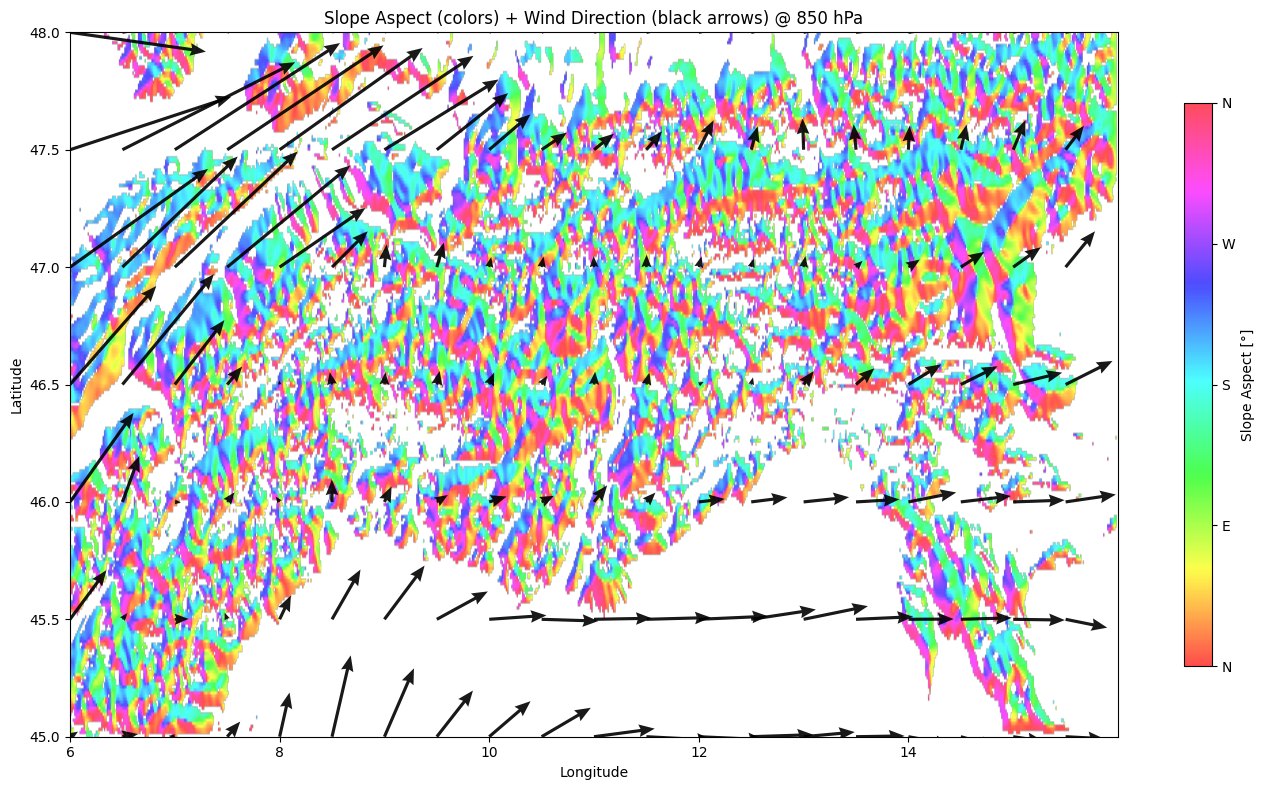


Mean wind: u=6.6 m/s, v=3.9 m/s
Mean wind direction: 239° (coming FROM)
Note: This ERA5 example has mostly westerly winds. South winds would better show perpendicular flow to N-facing slopes.


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Select one time and pressure level for visualization
time_idx = 7  # WSW wind @ 7.6 m/s
plev = 850  # hPa

# Crop ERA5 to terrain extent
terrain_lats = terrain_ds.latitude.values
terrain_lons = terrain_ds.longitude.values
lat_min, lat_max = terrain_lats.min(), terrain_lats.max()
lon_min, lon_max = terrain_lons.min(), terrain_lons.max()

# Select ERA5 data within terrain bounds
era5_crop = era5_enhanced.sel(
    latitude=slice(lat_max, lat_min),  # ERA5 lats are decreasing
    longitude=slice(lon_min, lon_max)
)
d
# Get data
aspect_deg = terrain_ds['aspect_deg'].values
terrain_mask = terrain_ds['terrain_mask'].values

# Wind at selected level
u = era5_crop['u'].isel(valid_time=time_idx).sel(pressure_level=plev).values
v = era5_crop['v'].isel(valid_time=time_idx).sel(pressure_level=plev).values
era5_lats = era5_crop.latitude.values
era5_lons = era5_crop.longitude.values

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot terrain aspect as background (masked to valid terrain)
aspect_masked = np.where(terrain_mask, aspect_deg, np.nan)
im = ax.imshow(aspect_masked, 
               extent=[terrain_lons[0], terrain_lons[-1], terrain_lats[-1], terrain_lats[0]], 
               cmap='hsv', vmin=0, vmax=360, aspect='auto', alpha=0.7)
cbar = plt.colorbar(im, ax=ax, label='Slope Aspect [°]', ticks=[0, 90, 180, 270, 360], shrink=0.8)
cbar.ax.set_yticklabels(['N', 'E', 'S', 'W', 'N'])

# Add wind arrows (quiver) in BLACK - subsample for clarity
skip = 2  # Plot every 2nd arrow
lon_grid, lat_grid = np.meshgrid(era5_lons[::skip], era5_lats[::skip])
u_sub = u[::skip, ::skip]
v_sub = v[::skip, ::skip]

ax.quiver(lon_grid, lat_grid, u_sub, v_sub,
          color='black', scale=150, width=0.003, alpha=0.9,
          headwidth=4, headlength=5)

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Slope Aspect (colors) + Wind Direction (black arrows) @ {plev} hPa')

plt.tight_layout()
plt.show()

# Show wind statistics
mean_u = np.nanmean(u)
mean_v = np.nanmean(v)
wind_dir_deg = (np.degrees(np.arctan2(-mean_u, -mean_v)) + 360) % 360
print(f"\nMean wind: u={mean_u:.1f} m/s, v={mean_v:.1f} m/s")
print(f"Mean wind direction: {wind_dir_deg:.0f}° (coming FROM)")
print("Note: This ERA5 example has mostly westerly winds. South winds would better show perpendicular flow to N-facing slopes.")

In [12]:
# Check wind direction for all time steps
print("Wind direction by time step (coming FROM):")
for t in range(len(era5_crop.valid_time)):
    u_t = era5_crop['u'].isel(valid_time=t).sel(pressure_level=plev).values
    v_t = era5_crop['v'].isel(valid_time=t).sel(pressure_level=plev).values
    mean_u = np.nanmean(u_t)
    mean_v = np.nanmean(v_t)
    wind_dir = (np.degrees(np.arctan2(-mean_u, -mean_v)) + 360) % 360
    speed = np.sqrt(mean_u**2 + mean_v**2)
    time_str = str(era5_crop.valid_time.values[t])[:16]
    print(f"  {t}: {time_str} - {wind_dir:5.0f}° @ {speed:.1f} m/s")

Wind direction by time step (coming FROM):
  0: 2025-10-01T00:00 -    59° @ 2.7 m/s
  1: 2025-10-01T12:00 -    48° @ 4.4 m/s
  2: 2025-10-02T00:00 -    57° @ 5.3 m/s
  3: 2025-10-02T12:00 -    40° @ 4.3 m/s
  4: 2025-10-03T00:00 -    48° @ 3.4 m/s
  5: 2025-10-03T12:00 -     4° @ 1.4 m/s
  6: 2025-10-04T00:00 -   269° @ 2.7 m/s
  7: 2025-10-04T12:00 -   239° @ 7.7 m/s
  8: 2025-10-05T00:00 -   265° @ 6.7 m/s
  9: 2025-10-05T12:00 -   312° @ 3.2 m/s


In [21]:
# Debug: check ERA5 data structure
print("ERA5 data structure:")
print(f"  u shape: {era5_data['u'].shape}")
print(f"  u dims: {era5_data['u'].dims}")
print(f"  z shape: {era5_data['z'].shape}")
print(f"  z dims: {era5_data['z'].dims}")
print(f"\nERA5 data dimensions:")
print(era5_data.dims)

ERA5 data structure:
  u shape: (10, 5, 161, 281)
  u dims: ('valid_time', 'pressure_level', 'latitude', 'longitude')
  z shape: (10, 5, 161, 281)
  z dims: ('valid_time', 'pressure_level', 'latitude', 'longitude')

ERA5 data dimensions:
FrozenMappingWarningOnValuesAccess({'valid_time': 10, 'pressure_level': 5, 'latitude': 161, 'longitude': 281})


In [24]:
# Reload modules to get updated functions
importlib.reload(wind)

# Test the new wind-terrain interaction function
# The new function searches downwind for terrain and computes wind-slope angles

print("Testing updated compute_wind_terrain_interaction...")
print("\nInput data shapes:")
print(f"  ERA5: {era5_data.sizes}")
print(f"  Terrain: {terrain_ds.sizes}")

# Call the new function
era5_new = wind.compute_wind_terrain_interaction(era5_data, terrain_ds, range_km=10.0)

print("\n✓ Computation complete!")
print("\nOutput variables added:")
print(f"  - wind_speed: {era5_new['wind_speed'].shape}")
print(f"  - wind_direction: {era5_new['wind_direction'].shape}")
print(f"  - downwind_terrain_height: {era5_new['downwind_terrain_height'].shape}")
print(f"  - wind_slope_angle: {era5_new['wind_slope_angle'].shape}")

print("\nDataset:")
print(era5_new)

# Check some statistics
print("\n--- Wind-Terrain Statistics ---")
wind_speed = era5_new['wind_speed']
terrain_height = era5_new['downwind_terrain_height']
wind_angle = era5_new['wind_slope_angle']

print(f"Wind speed: {wind_speed.mean().values:.2f} ± {wind_speed.std().values:.2f} m/s")
print(f"Downwind terrain height: {np.nanmean(terrain_height.values):.0f} ± {np.nanstd(terrain_height.values):.0f} m")
print(f"Wind-slope angle: {np.nanmean(wind_angle.values):.3f} ± {np.nanstd(wind_angle.values):.3f} rad")
print(f"Points with terrain detected: {np.sum(~np.isnan(terrain_height.values))}/{terrain_height.size}")


Testing updated compute_wind_terrain_interaction...

Input data shapes:
  ERA5: Frozen({'valid_time': 10, 'pressure_level': 5, 'latitude': 13, 'longitude': 40})
  Terrain: Frozen({'latitude': 232, 'longitude': 772})

✓ Computation complete!

Output variables added:
  - wind_speed: (10, 5, 13, 40)
  - wind_direction: (10, 5, 13, 40)
  - downwind_terrain_height: (10, 5, 13, 40)
  - wind_slope_angle: (10, 5, 13, 40)

Dataset:
<xarray.Dataset> Size: 729kB
Dimensions:                  (valid_time: 10, pressure_level: 5, latitude: 13,
                              longitude: 40)
Coordinates:
  * valid_time               (valid_time) datetime64[ns] 80B 2025-10-01 ... 2...
  * pressure_level           (pressure_level) float64 40B 925.0 850.0 ... 300.0
  * latitude                 (latitude) float64 104B 48.0 47.75 ... 45.25 45.0
  * longitude                (longitude) float64 320B 6.0 6.25 ... 15.5 15.75
    number                   int64 8B ...
    expver                   (valid_time) <U4 1

In [25]:
era5_new

<xarray.Dataset> Size: 729kB
Dimensions:                  (valid_time: 10, pressure_level: 5, latitude: 13,
                              longitude: 40)
Coordinates:
  * valid_time               (valid_time) datetime64[ns] 80B 2025-10-01 ... 2...
  * pressure_level           (pressure_level) float64 40B 925.0 850.0 ... 300.0
  * latitude                 (latitude) float64 104B 48.0 47.75 ... 45.25 45.0
  * longitude                (longitude) float64 320B 6.0 6.25 ... 15.5 15.75
    number                   int64 8B ...
    expver                   (valid_time) <U4 160B ...
Data variables:
    z                        (valid_time, pressure_level, latitude, longitude) float32 104kB ...
    u                        (valid_time, pressure_level, latitude, longitude) float32 104kB ...
    v                        (valid_time, pressure_level, latitude, longitude) float32 104kB ...
    wind_speed               (valid_time, pressure_level, latitude, longitude) float32 104kB ...
    wind_direction           (valid_time, pressure_level, latitude, longitude) float32 104kB ...
    downwind_terrain_height  (valid_time, pressure_level, latitude, longitude) float32 104kB ...
    wind_slope_angle         (valid_time, pressure_level, latitude, longitude) float32 104kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-05T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

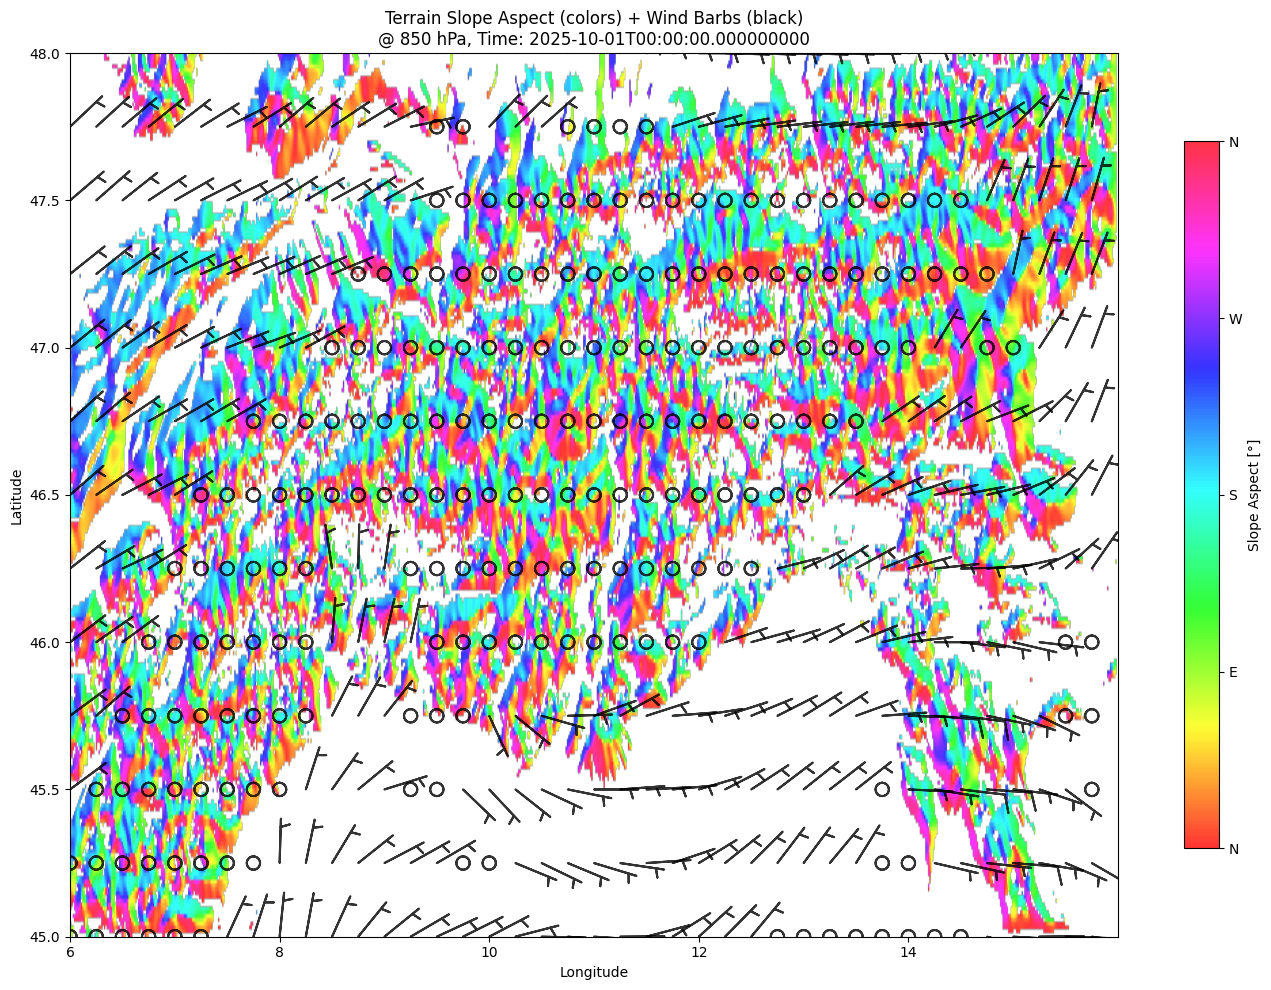


Wind Statistics @ 850 hPa:
  Mean speed: 3.2 m/s
  Std Dev: 1.9 m/s
  Min: 0.0 m/s
  Max: 8.4 m/s


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Select one time and pressure level for visualization
time_idx = 0
plev = 850  # hPa

# Get terrain aspect
aspect_deg = terrain_ds['aspect_deg'].values
terrain_mask = terrain_ds['terrain_mask'].values
terrain_lats = terrain_ds.latitude.values
terrain_lons = terrain_ds.longitude.values

# Get wind components at this level from ERA5 grid
u_wind = era5_new['u'].sel(pressure_level=plev, valid_time=era5_new.valid_time[time_idx], method='nearest').values
v_wind = era5_new['v'].sel(pressure_level=plev, valid_time=era5_new.valid_time[time_idx], method='nearest').values

era5_lats = era5_new.latitude.values
era5_lons = era5_new.longitude.values

In [46]:
era5_test_enhanced

<xarray.Dataset> Size: 15kB
Dimensions:                  (valid_time: 1, pressure_level: 1, latitude: 13,
                              longitude: 40)
Coordinates:
  * valid_time               (valid_time) datetime64[s] 8B 2025-01-02
  * pressure_level           (pressure_level) int64 8B 850
  * latitude                 (latitude) float64 104B 48.0 47.75 ... 45.25 45.0
  * longitude                (longitude) float64 320B 6.0 6.25 ... 15.5 15.75
Data variables:
    u                        (valid_time, pressure_level, latitude, longitude) float32 2kB ...
    v                        (valid_time, pressure_level, latitude, longitude) float32 2kB ...
    z                        (valid_time, pressure_level, latitude, longitude) float32 2kB ...
    wind_speed               (valid_time, pressure_level, latitude, longitude) float32 2kB ...
    wind_direction           (valid_time, pressure_level, latitude, longitude) float32 2kB ...
    downwind_terrain_height  (valid_time, pressure_level, latitude, longitude) float32 2kB ...
    wind_slope_angle         (valid_time, pressure_level, latitude, longitude) float32 2kB ...

In [ ]:
def calc_wind(u, v):
    """
    Compute wind direction in degrees from u and v components.
    Meteorological convention: 0° = from North, 90° = from East, 180° = from South, 270° = from West.
    
    Parameters:
    u : array-like
        U-component of wind (east-west).
    v : array-like
        V-component of wind (north-south).
        
    Returns:
    wind_dir : array-like
        Wind direction in degrees.
    """
    wind_dir = (np.degrees(np.arctan2(-u, -v)) + 360) % 360
    wind_speed = np.sqrt(u**2 + v**2)
    return wind_dir, wind_speed

In [ ]:
def perpendicular_wind_component(wind_dir, wind_speed, slope_aspect):
    """
    Compute the perpendicular component of wind relative to a slope aspect.
    
    The perpendicular component is the projection of wind speed onto the direction
    perpendicular to the slope (i.e., wind blowing INTO the slope).
    
    Parameters:
    wind_dir : float
        Wind direction in degrees (0-360, meteorological convention: 0=N, 90=E, 180=S, 270=W).
    wind_speed : float
        Wind speed in m/s.
    slope_aspect : float
        Slope aspect direction in degrees (0-360, direction the slope faces).
        
    Returns:
    perpendicular_wind_speed : float
        Component of wind speed perpendicular to slope. Positive = wind into slope.
    """
    if wind_dir < 0 or wind_dir > 360:
        raise ValueError("Wind direction must be between 0 and 360 degrees.")
    if slope_aspect < 0 or slope_aspect > 360:
        raise ValueError("Slope aspect must be between 0 and 360 degrees.")
    
    # Compute the angle difference between wind direction and slope aspect
    # This gives us how aligned the wind is with the slope
    angle_diff = (wind_dir - slope_aspect) % 360
    
    # Normalize to [-180, 180] for easier interpretation
    if angle_diff > 180:
        angle_diff -= 360
    
    # Check if wind is within ±90° of slope aspect (wind blowing toward the slope)
    # If |angle_diff| <= 90°, the wind has a component toward the slope
    if abs(angle_diff) <= 90:
        perpendicular_wind_speed = wind_speed * np.cos(np.radians(angle_diff))
    else:
        # Wind is blowing away from the slope
        perpendicular_wind_speed = 0
    
    return np.round(perpendicular_wind_speed,2)


In [105]:
per = perpendicular_wind_component(45, 10, 0)
per

np.float64(7.07)